<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:59:46] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


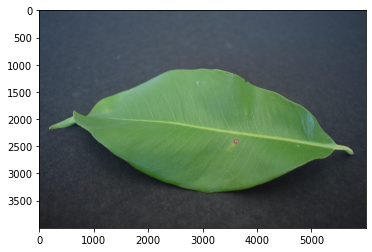

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

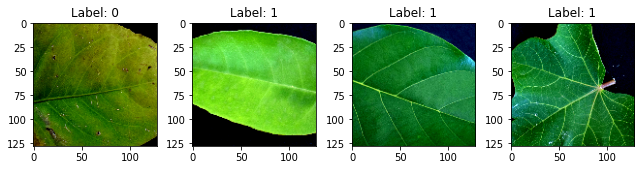

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:59:52] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:59:54] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.251785171748355 samples/sec                   batch loss = 0.9627739191055298 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.261632064789165 samples/sec                   batch loss = 0.5724563002586365 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.26500518338569 samples/sec                   batch loss = 0.8980359435081482 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.263441714908955 samples/sec                   batch loss = 1.1419156789779663 | accuracy = 0.65


Epoch[1] Batch[25] Speed: 1.2604654398604873 samples/sec                   batch loss = 0.49206534028053284 | accuracy = 0.65


Epoch[1] Batch[30] Speed: 1.2624800456675225 samples/sec                   batch loss = 0.5344128608703613 | accuracy = 0.675


Epoch[1] Batch[35] Speed: 1.2624816606902045 samples/sec                   batch loss = 0.7496288418769836 | accuracy = 0.6642857142857143


Epoch[1] Batch[40] Speed: 1.261258088934052 samples/sec                   batch loss = 0.947734534740448 | accuracy = 0.65625


Epoch[1] Batch[45] Speed: 1.2595700414630975 samples/sec                   batch loss = 0.23951604962348938 | accuracy = 0.6555555555555556


Epoch[1] Batch[50] Speed: 1.265246735774076 samples/sec                   batch loss = 0.578779935836792 | accuracy = 0.645


Epoch[1] Batch[55] Speed: 1.2656087600090584 samples/sec                   batch loss = 0.36073893308639526 | accuracy = 0.6681818181818182


Epoch[1] Batch[60] Speed: 1.2631740307953903 samples/sec                   batch loss = 0.6409770250320435 | accuracy = 0.6666666666666666


Epoch[1] Batch[65] Speed: 1.2656086645364 samples/sec                   batch loss = 0.48330289125442505 | accuracy = 0.676923076923077


Epoch[1] Batch[70] Speed: 1.2567412923826369 samples/sec                   batch loss = 0.30403509736061096 | accuracy = 0.6642857142857143


Epoch[1] Batch[75] Speed: 1.263172699317194 samples/sec                   batch loss = 0.4417686462402344 | accuracy = 0.66


Epoch[1] Batch[80] Speed: 1.265973093079479 samples/sec                   batch loss = 0.5026480555534363 | accuracy = 0.6625


Epoch[1] Batch[85] Speed: 1.2702471472238148 samples/sec                   batch loss = 0.43452590703964233 | accuracy = 0.6617647058823529


Epoch[1] Batch[90] Speed: 1.264854021576351 samples/sec                   batch loss = 0.5351851582527161 | accuracy = 0.6583333333333333


Epoch[1] Batch[95] Speed: 1.256289114852116 samples/sec                   batch loss = 0.8569605350494385 | accuracy = 0.65


Epoch[1] Batch[100] Speed: 1.2625580464820372 samples/sec                   batch loss = 0.4259210526943207 | accuracy = 0.6575


Epoch[1] Batch[105] Speed: 1.2648857768641144 samples/sec                   batch loss = 1.1067099571228027 | accuracy = 0.6523809523809524


Epoch[1] Batch[110] Speed: 1.2665998735152824 samples/sec                   batch loss = 0.9630152583122253 | accuracy = 0.6568181818181819


Epoch[1] Batch[115] Speed: 1.2593558909541098 samples/sec                   batch loss = 0.39511340856552124 | accuracy = 0.6521739130434783


Epoch[1] Batch[120] Speed: 1.254599791034838 samples/sec                   batch loss = 0.8559239506721497 | accuracy = 0.6541666666666667


Epoch[1] Batch[125] Speed: 1.2607017563106977 samples/sec                   batch loss = 0.44473567605018616 | accuracy = 0.654


Epoch[1] Batch[130] Speed: 1.2604066349859946 samples/sec                   batch loss = 1.2050851583480835 | accuracy = 0.6576923076923077


Epoch[1] Batch[135] Speed: 1.269111677893512 samples/sec                   batch loss = 0.5673127770423889 | accuracy = 0.6611111111111111


Epoch[1] Batch[140] Speed: 1.2510768652564983 samples/sec                   batch loss = 0.244871124625206 | accuracy = 0.6696428571428571


Epoch[1] Batch[145] Speed: 1.2609919926498574 samples/sec                   batch loss = 0.6525521278381348 | accuracy = 0.6706896551724137


Epoch[1] Batch[150] Speed: 1.2642375412753888 samples/sec                   batch loss = 0.48612180352211 | accuracy = 0.6733333333333333


Epoch[1] Batch[155] Speed: 1.2597198482799343 samples/sec                   batch loss = 0.3013441860675812 | accuracy = 0.6725806451612903


Epoch[1] Batch[160] Speed: 1.261565277285876 samples/sec                   batch loss = 0.5993350148200989 | accuracy = 0.678125


Epoch[1] Batch[165] Speed: 1.2581505387697656 samples/sec                   batch loss = 0.7466102838516235 | accuracy = 0.6772727272727272


Epoch[1] Batch[170] Speed: 1.258579320270893 samples/sec                   batch loss = 1.2954131364822388 | accuracy = 0.675


Epoch[1] Batch[175] Speed: 1.2587744120274171 samples/sec                   batch loss = 0.8902550935745239 | accuracy = 0.6728571428571428


Epoch[1] Batch[180] Speed: 1.2679936656305133 samples/sec                   batch loss = 0.6953445076942444 | accuracy = 0.6722222222222223


Epoch[1] Batch[185] Speed: 1.2593919085280536 samples/sec                   batch loss = 0.4477977454662323 | accuracy = 0.6702702702702703


Epoch[1] Batch[190] Speed: 1.2591109126819287 samples/sec                   batch loss = 0.8463202714920044 | accuracy = 0.6723684210526316


Epoch[1] Batch[195] Speed: 1.2642843185623893 samples/sec                   batch loss = 0.444932758808136 | accuracy = 0.6717948717948717


Epoch[1] Batch[200] Speed: 1.26095332465902 samples/sec                   batch loss = 2.166076898574829 | accuracy = 0.66875


Epoch[1] Batch[205] Speed: 1.26084036705411 samples/sec                   batch loss = 0.6502090096473694 | accuracy = 0.6658536585365854


Epoch[1] Batch[210] Speed: 1.256803898266791 samples/sec                   batch loss = 0.3877128064632416 | accuracy = 0.6654761904761904


Epoch[1] Batch[215] Speed: 1.262618762678141 samples/sec                   batch loss = 0.5342197418212891 | accuracy = 0.6697674418604651


Epoch[1] Batch[220] Speed: 1.2643322426720993 samples/sec                   batch loss = 0.3872823417186737 | accuracy = 0.6704545454545454


Epoch[1] Batch[225] Speed: 1.2594054274668156 samples/sec                   batch loss = 0.5788270235061646 | accuracy = 0.6688888888888889


Epoch[1] Batch[230] Speed: 1.2626584831615593 samples/sec                   batch loss = 0.36434224247932434 | accuracy = 0.6684782608695652


Epoch[1] Batch[235] Speed: 1.2547161373099627 samples/sec                   batch loss = 0.2546156346797943 | accuracy = 0.6691489361702128


Epoch[1] Batch[240] Speed: 1.260535141632377 samples/sec                   batch loss = 0.47568607330322266 | accuracy = 0.6697916666666667


Epoch[1] Batch[245] Speed: 1.2653476006974294 samples/sec                   batch loss = 0.5837560296058655 | accuracy = 0.6683673469387755


Epoch[1] Batch[250] Speed: 1.2643074703128572 samples/sec                   batch loss = 0.5420236587524414 | accuracy = 0.669


Epoch[1] Batch[255] Speed: 1.2508925458590077 samples/sec                   batch loss = 0.9509996771812439 | accuracy = 0.6656862745098039


Epoch[1] Batch[260] Speed: 1.2584833074768864 samples/sec                   batch loss = 0.20360404253005981 | accuracy = 0.6692307692307692


Epoch[1] Batch[265] Speed: 1.2620767044191523 samples/sec                   batch loss = 0.7896960973739624 | accuracy = 0.6669811320754717


Epoch[1] Batch[270] Speed: 1.2632054164514859 samples/sec                   batch loss = 0.4817821681499481 | accuracy = 0.6657407407407407


Epoch[1] Batch[275] Speed: 1.263506036878357 samples/sec                   batch loss = 0.12687215209007263 | accuracy = 0.6663636363636364


Epoch[1] Batch[280] Speed: 1.2562078421042622 samples/sec                   batch loss = 1.1587218046188354 | accuracy = 0.66875


Epoch[1] Batch[285] Speed: 1.2637068472867183 samples/sec                   batch loss = 0.42607438564300537 | accuracy = 0.6736842105263158


Epoch[1] Batch[290] Speed: 1.2633938582845325 samples/sec                   batch loss = 0.23660771548748016 | accuracy = 0.6758620689655173


Epoch[1] Batch[295] Speed: 1.2643990376010115 samples/sec                   batch loss = 0.36677783727645874 | accuracy = 0.6754237288135593


Epoch[1] Batch[300] Speed: 1.2633717864707026 samples/sec                   batch loss = 0.6233583688735962 | accuracy = 0.6716666666666666


Epoch[1] Batch[305] Speed: 1.254600541586814 samples/sec                   batch loss = 0.8617318868637085 | accuracy = 0.671311475409836


Epoch[1] Batch[310] Speed: 1.2628695757883235 samples/sec                   batch loss = 0.6862072348594666 | accuracy = 0.6717741935483871


Epoch[1] Batch[315] Speed: 1.2601390994789534 samples/sec                   batch loss = 0.24027535319328308 | accuracy = 0.6722222222222223


Epoch[1] Batch[320] Speed: 1.2593459652131642 samples/sec                   batch loss = 0.2512248158454895 | accuracy = 0.67265625


Epoch[1] Batch[325] Speed: 1.26338795970705 samples/sec                   batch loss = 0.42155030369758606 | accuracy = 0.6730769230769231


Epoch[1] Batch[330] Speed: 1.259539403548917 samples/sec                   batch loss = 0.5419246554374695 | accuracy = 0.6757575757575758


Epoch[1] Batch[335] Speed: 1.2626851866137676 samples/sec                   batch loss = 0.160592183470726 | accuracy = 0.673134328358209


Epoch[1] Batch[340] Speed: 1.2629270896142013 samples/sec                   batch loss = 0.43580999970436096 | accuracy = 0.6720588235294118


Epoch[1] Batch[345] Speed: 1.2642314442872726 samples/sec                   batch loss = 0.6008619070053101 | accuracy = 0.6717391304347826


Epoch[1] Batch[350] Speed: 1.2512067423043982 samples/sec                   batch loss = 0.5359713435173035 | accuracy = 0.6728571428571428


Epoch[1] Batch[355] Speed: 1.2581556337304656 samples/sec                   batch loss = 0.7003100514411926 | accuracy = 0.6732394366197183


Epoch[1] Batch[360] Speed: 1.2614497440140366 samples/sec                   batch loss = 0.7736170291900635 | accuracy = 0.6715277777777777


Epoch[1] Batch[365] Speed: 1.268569115257589 samples/sec                   batch loss = 0.5804014801979065 | accuracy = 0.6705479452054794


Epoch[1] Batch[370] Speed: 1.2641810511217022 samples/sec                   batch loss = 0.43782666325569153 | accuracy = 0.6716216216216216


Epoch[1] Batch[375] Speed: 1.2570243394450988 samples/sec                   batch loss = 0.7545332312583923 | accuracy = 0.6726666666666666


Epoch[1] Batch[380] Speed: 1.2638343141099706 samples/sec                   batch loss = 0.23777875304222107 | accuracy = 0.6730263157894737


Epoch[1] Batch[385] Speed: 1.2669606634055015 samples/sec                   batch loss = 0.3476875424385071 | accuracy = 0.672077922077922


Epoch[1] Batch[390] Speed: 1.2704723298899436 samples/sec                   batch loss = 0.36651524901390076 | accuracy = 0.6698717948717948


Epoch[1] Batch[395] Speed: 1.2613829758120128 samples/sec                   batch loss = 0.731360912322998 | accuracy = 0.6670886075949367


Epoch[1] Batch[400] Speed: 1.2573234381496563 samples/sec                   batch loss = 0.5744367241859436 | accuracy = 0.666875


Epoch[1] Batch[405] Speed: 1.2613759579740234 samples/sec                   batch loss = 0.6232223510742188 | accuracy = 0.6679012345679012


Epoch[1] Batch[410] Speed: 1.2609659294053064 samples/sec                   batch loss = 0.6092283129692078 | accuracy = 0.6676829268292683


Epoch[1] Batch[415] Speed: 1.2647210099967985 samples/sec                   batch loss = 0.622992992401123 | accuracy = 0.6680722891566265


Epoch[1] Batch[420] Speed: 1.2603607122895795 samples/sec                   batch loss = 0.6217796802520752 | accuracy = 0.6678571428571428


Epoch[1] Batch[425] Speed: 1.264159523319212 samples/sec                   batch loss = 0.4851245880126953 | accuracy = 0.67


Epoch[1] Batch[430] Speed: 1.265998312879188 samples/sec                   batch loss = 0.6862834692001343 | accuracy = 0.6715116279069767


Epoch[1] Batch[435] Speed: 1.2714636588656223 samples/sec                   batch loss = 0.9234178066253662 | accuracy = 0.6706896551724137


Epoch[1] Batch[440] Speed: 1.2720170912254316 samples/sec                   batch loss = 0.6248117089271545 | accuracy = 0.6698863636363637


Epoch[1] Batch[445] Speed: 1.264483565693737 samples/sec                   batch loss = 0.3693951368331909 | accuracy = 0.6724719101123595


Epoch[1] Batch[450] Speed: 1.269261938640445 samples/sec                   batch loss = 0.6962941288948059 | accuracy = 0.6733333333333333


Epoch[1] Batch[455] Speed: 1.264036847891168 samples/sec                   batch loss = 1.106526494026184 | accuracy = 0.6730769230769231


Epoch[1] Batch[460] Speed: 1.2675544243554686 samples/sec                   batch loss = 0.39868974685668945 | accuracy = 0.6722826086956522


Epoch[1] Batch[465] Speed: 1.2555811536379877 samples/sec                   batch loss = 0.3962605595588684 | accuracy = 0.6731182795698925


Epoch[1] Batch[470] Speed: 1.2521810261602229 samples/sec                   batch loss = 0.46514514088630676 | accuracy = 0.6728723404255319


Epoch[1] Batch[475] Speed: 1.2665660241413723 samples/sec                   batch loss = 0.3601742684841156 | accuracy = 0.6731578947368421


Epoch[1] Batch[480] Speed: 1.2661846266169456 samples/sec                   batch loss = 0.9091870784759521 | accuracy = 0.6734375


Epoch[1] Batch[485] Speed: 1.2643694030311918 samples/sec                   batch loss = 0.44587212800979614 | accuracy = 0.6747422680412372


Epoch[1] Batch[490] Speed: 1.2607515882432463 samples/sec                   batch loss = 0.7272846698760986 | accuracy = 0.6755102040816326


Epoch[1] Batch[495] Speed: 1.2640114204828239 samples/sec                   batch loss = 0.6585683822631836 | accuracy = 0.6767676767676768


Epoch[1] Batch[500] Speed: 1.266312498230982 samples/sec                   batch loss = 0.5621759295463562 | accuracy = 0.677


Epoch[1] Batch[505] Speed: 1.2689729703236448 samples/sec                   batch loss = 0.1783764362335205 | accuracy = 0.6777227722772278


Epoch[1] Batch[510] Speed: 1.2636455505177928 samples/sec                   batch loss = 0.6520435810089111 | accuracy = 0.6784313725490196


Epoch[1] Batch[515] Speed: 1.2595081997980548 samples/sec                   batch loss = 0.32873234152793884 | accuracy = 0.6796116504854369


Epoch[1] Batch[520] Speed: 1.2656816098460115 samples/sec                   batch loss = 0.674755334854126 | accuracy = 0.6788461538461539


Epoch[1] Batch[525] Speed: 1.2591322688773032 samples/sec                   batch loss = 0.5514338612556458 | accuracy = 0.679047619047619


Epoch[1] Batch[530] Speed: 1.2683443190329107 samples/sec                   batch loss = 0.38015633821487427 | accuracy = 0.680188679245283


Epoch[1] Batch[535] Speed: 1.2614079182195348 samples/sec                   batch loss = 0.6613105535507202 | accuracy = 0.680841121495327


Epoch[1] Batch[540] Speed: 1.2620860086586847 samples/sec                   batch loss = 0.44798046350479126 | accuracy = 0.6819444444444445


Epoch[1] Batch[545] Speed: 1.260500573893406 samples/sec                   batch loss = 0.16975973546504974 | accuracy = 0.6830275229357798


Epoch[1] Batch[550] Speed: 1.26505879013015 samples/sec                   batch loss = 0.28453579545021057 | accuracy = 0.6845454545454546


Epoch[1] Batch[555] Speed: 1.2687047603909076 samples/sec                   batch loss = 0.3592436909675598 | accuracy = 0.6855855855855856


Epoch[1] Batch[560] Speed: 1.2611169216304512 samples/sec                   batch loss = 0.5784507989883423 | accuracy = 0.6848214285714286


Epoch[1] Batch[565] Speed: 1.2667864600188554 samples/sec                   batch loss = 0.41809797286987305 | accuracy = 0.6867256637168142


Epoch[1] Batch[570] Speed: 1.263146926256569 samples/sec                   batch loss = 0.5870006680488586 | accuracy = 0.6872807017543859


Epoch[1] Batch[575] Speed: 1.266035093554993 samples/sec                   batch loss = 0.7230815291404724 | accuracy = 0.6882608695652174


Epoch[1] Batch[580] Speed: 1.2658942876812422 samples/sec                   batch loss = 0.09387332946062088 | accuracy = 0.6883620689655172


Epoch[1] Batch[585] Speed: 1.2538778009163347 samples/sec                   batch loss = 0.36936503648757935 | accuracy = 0.6884615384615385


Epoch[1] Batch[590] Speed: 1.2626097356440669 samples/sec                   batch loss = 0.6938673257827759 | accuracy = 0.688135593220339


Epoch[1] Batch[595] Speed: 1.2648946457428327 samples/sec                   batch loss = 0.21336393058300018 | accuracy = 0.688655462184874


Epoch[1] Batch[600] Speed: 1.2647676323767298 samples/sec                   batch loss = 0.6222554445266724 | accuracy = 0.68875


Epoch[1] Batch[605] Speed: 1.2644617416878934 samples/sec                   batch loss = 0.7106160521507263 | accuracy = 0.6892561983471074


Epoch[1] Batch[610] Speed: 1.2666265526865923 samples/sec                   batch loss = 0.31540483236312866 | accuracy = 0.6893442622950819


Epoch[1] Batch[615] Speed: 1.267867657994363 samples/sec                   batch loss = 0.8836904764175415 | accuracy = 0.6898373983739837


Epoch[1] Batch[620] Speed: 1.266239958024501 samples/sec                   batch loss = 0.6561846137046814 | accuracy = 0.6903225806451613


Epoch[1] Batch[625] Speed: 1.2663301805687959 samples/sec                   batch loss = 1.1033127307891846 | accuracy = 0.6908


Epoch[1] Batch[630] Speed: 1.2637175082014036 samples/sec                   batch loss = 0.5609084963798523 | accuracy = 0.6908730158730159


Epoch[1] Batch[635] Speed: 1.2573793170847671 samples/sec                   batch loss = 0.249094620347023 | accuracy = 0.6917322834645669


Epoch[1] Batch[640] Speed: 1.2630024834387854 samples/sec                   batch loss = 0.17845214903354645 | accuracy = 0.693359375


Epoch[1] Batch[645] Speed: 1.261500773342577 samples/sec                   batch loss = 0.944223165512085 | accuracy = 0.6934108527131783


Epoch[1] Batch[650] Speed: 1.2660135025615749 samples/sec                   batch loss = 0.30741479992866516 | accuracy = 0.6934615384615385


Epoch[1] Batch[655] Speed: 1.2588440213519767 samples/sec                   batch loss = 0.7761437296867371 | accuracy = 0.6942748091603054


Epoch[1] Batch[660] Speed: 1.261913048187429 samples/sec                   batch loss = 0.5922244191169739 | accuracy = 0.6946969696969697


Epoch[1] Batch[665] Speed: 1.2632854093731454 samples/sec                   batch loss = 0.264362096786499 | accuracy = 0.693984962406015


Epoch[1] Batch[670] Speed: 1.264553236010895 samples/sec                   batch loss = 0.2054544985294342 | accuracy = 0.6944029850746268


Epoch[1] Batch[675] Speed: 1.2659781560647172 samples/sec                   batch loss = 0.7938960194587708 | accuracy = 0.6940740740740741


Epoch[1] Batch[680] Speed: 1.2595703251544526 samples/sec                   batch loss = 0.9749117493629456 | accuracy = 0.6941176470588235


Epoch[1] Batch[685] Speed: 1.262666085452877 samples/sec                   batch loss = 0.2256051003932953 | accuracy = 0.6948905109489051


Epoch[1] Batch[690] Speed: 1.2672023889595818 samples/sec                   batch loss = 0.28669214248657227 | accuracy = 0.6949275362318841


Epoch[1] Batch[695] Speed: 1.268983048398861 samples/sec                   batch loss = 0.489270955324173 | accuracy = 0.6942446043165468


Epoch[1] Batch[700] Speed: 1.2578425590052669 samples/sec                   batch loss = 0.6009869575500488 | accuracy = 0.6932142857142857


Epoch[1] Batch[705] Speed: 1.2628056988030785 samples/sec                   batch loss = 0.48913171887397766 | accuracy = 0.6939716312056737


Epoch[1] Batch[710] Speed: 1.252241869974527 samples/sec                   batch loss = 0.3494490683078766 | accuracy = 0.6950704225352112


Epoch[1] Batch[715] Speed: 1.265401522791604 samples/sec                   batch loss = 0.6196857690811157 | accuracy = 0.6937062937062937


Epoch[1] Batch[720] Speed: 1.2647943297656394 samples/sec                   batch loss = 1.2227756977081299 | accuracy = 0.6930555555555555


Epoch[1] Batch[725] Speed: 1.2550921583521841 samples/sec                   batch loss = 0.5036683082580566 | accuracy = 0.6941379310344827


Epoch[1] Batch[730] Speed: 1.263191530483995 samples/sec                   batch loss = 0.47978487610816956 | accuracy = 0.6941780821917808


Epoch[1] Batch[735] Speed: 1.266018661404548 samples/sec                   batch loss = 0.7478315234184265 | accuracy = 0.6928571428571428


Epoch[1] Batch[740] Speed: 1.266609053318368 samples/sec                   batch loss = 0.6082935929298401 | accuracy = 0.6929054054054054


Epoch[1] Batch[745] Speed: 1.2675082666131576 samples/sec                   batch loss = 0.33756589889526367 | accuracy = 0.6929530201342282


Epoch[1] Batch[750] Speed: 1.264757621146457 samples/sec                   batch loss = 0.7311232686042786 | accuracy = 0.6926666666666667


Epoch[1] Batch[755] Speed: 1.264284032743608 samples/sec                   batch loss = 0.5938950181007385 | accuracy = 0.6927152317880795


Epoch[1] Batch[760] Speed: 1.2619353538179878 samples/sec                   batch loss = 0.6329483389854431 | accuracy = 0.6930921052631579


Epoch[1] Batch[765] Speed: 1.2608034138422515 samples/sec                   batch loss = 0.7944259643554688 | accuracy = 0.6928104575163399


Epoch[1] Batch[770] Speed: 1.2570865967686464 samples/sec                   batch loss = 0.40933093428611755 | accuracy = 0.6935064935064935


Epoch[1] Batch[775] Speed: 1.2602439795524158 samples/sec                   batch loss = 0.6464474201202393 | accuracy = 0.6941935483870968


Epoch[1] Batch[780] Speed: 1.2631798322688637 samples/sec                   batch loss = 0.48726436495780945 | accuracy = 0.6939102564102564


Epoch[1] Batch[785] Speed: 1.2642489732866131 samples/sec                   batch loss = 0.8361145853996277 | accuracy = 0.693312101910828


[Epoch 1] training: accuracy=0.6932106598984772
[Epoch 1] time cost: 671.4909694194794
[Epoch 1] validation: validation accuracy=0.7322222222222222


Epoch[2] Batch[5] Speed: 1.2626851866137676 samples/sec                   batch loss = 0.459898442029953 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.25659275781372 samples/sec                   batch loss = 0.4456818699836731 | accuracy = 0.625


Epoch[2] Batch[15] Speed: 1.2540147276254834 samples/sec                   batch loss = 0.4083009958267212 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2547321835297225 samples/sec                   batch loss = 0.5754489898681641 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.2625433196462366 samples/sec                   batch loss = 0.14379730820655823 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2623850516030963 samples/sec                   batch loss = 0.6751790046691895 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.2647605768265253 samples/sec                   batch loss = 0.5144937038421631 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.2551715026095516 samples/sec                   batch loss = 0.3611656427383423 | accuracy = 0.76875


Epoch[2] Batch[45] Speed: 1.2546039190818186 samples/sec                   batch loss = 0.2395012378692627 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.2625189973664812 samples/sec                   batch loss = 0.28639185428619385 | accuracy = 0.785


Epoch[2] Batch[55] Speed: 1.2691799389088778 samples/sec                   batch loss = 0.46322721242904663 | accuracy = 0.7772727272727272


Epoch[2] Batch[60] Speed: 1.267933581299063 samples/sec                   batch loss = 0.17127984762191772 | accuracy = 0.7875


Epoch[2] Batch[65] Speed: 1.2610286725681277 samples/sec                   batch loss = 0.33488932251930237 | accuracy = 0.7884615384615384


Epoch[2] Batch[70] Speed: 1.263357326045308 samples/sec                   batch loss = 0.5353233218193054 | accuracy = 0.7857142857142857


Epoch[2] Batch[75] Speed: 1.2681297628423036 samples/sec                   batch loss = 0.32549718022346497 | accuracy = 0.78


Epoch[2] Batch[80] Speed: 1.2584597077548685 samples/sec                   batch loss = 1.4357831478118896 | accuracy = 0.771875


Epoch[2] Batch[85] Speed: 1.2646590428289284 samples/sec                   batch loss = 0.1822112500667572 | accuracy = 0.7676470588235295


Epoch[2] Batch[90] Speed: 1.2607352929573095 samples/sec                   batch loss = 0.8731885552406311 | accuracy = 0.7638888888888888


Epoch[2] Batch[95] Speed: 1.2639862797814976 samples/sec                   batch loss = 0.758985161781311 | accuracy = 0.7605263157894737


Epoch[2] Batch[100] Speed: 1.2593390645521372 samples/sec                   batch loss = 0.6121279001235962 | accuracy = 0.76


Epoch[2] Batch[105] Speed: 1.2683973461147713 samples/sec                   batch loss = 0.4137629270553589 | accuracy = 0.7571428571428571


Epoch[2] Batch[110] Speed: 1.2564349430151893 samples/sec                   batch loss = 0.4019225835800171 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.2675323984574336 samples/sec                   batch loss = 0.7218579053878784 | accuracy = 0.75


Epoch[2] Batch[120] Speed: 1.2669961604703193 samples/sec                   batch loss = 0.8427631258964539 | accuracy = 0.75


Epoch[2] Batch[125] Speed: 1.2754885159995837 samples/sec                   batch loss = 0.3379089832305908 | accuracy = 0.758


Epoch[2] Batch[130] Speed: 1.2593367958581811 samples/sec                   batch loss = 0.3614546060562134 | accuracy = 0.7596153846153846


Epoch[2] Batch[135] Speed: 1.2665818967863418 samples/sec                   batch loss = 0.47452715039253235 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.2681667633319256 samples/sec                   batch loss = 0.32311955094337463 | accuracy = 0.7642857142857142


Epoch[2] Batch[145] Speed: 1.2609210083780986 samples/sec                   batch loss = 0.41927313804626465 | accuracy = 0.7655172413793103


Epoch[2] Batch[150] Speed: 1.2662901331704646 samples/sec                   batch loss = 0.17439669370651245 | accuracy = 0.7666666666666667


Epoch[2] Batch[155] Speed: 1.2702357988224369 samples/sec                   batch loss = 0.26218217611312866 | accuracy = 0.7661290322580645


Epoch[2] Batch[160] Speed: 1.2602107530189985 samples/sec                   batch loss = 0.5787345170974731 | accuracy = 0.765625


Epoch[2] Batch[165] Speed: 1.2622645247142825 samples/sec                   batch loss = 1.1464664936065674 | accuracy = 0.7560606060606061


Epoch[2] Batch[170] Speed: 1.2710854696807554 samples/sec                   batch loss = 0.2536033093929291 | accuracy = 0.7573529411764706


Epoch[2] Batch[175] Speed: 1.2646818269739735 samples/sec                   batch loss = 0.442855566740036 | accuracy = 0.7514285714285714


Epoch[2] Batch[180] Speed: 1.2636236602556874 samples/sec                   batch loss = 0.3736855387687683 | accuracy = 0.7527777777777778


Epoch[2] Batch[185] Speed: 1.2657970601172301 samples/sec                   batch loss = 0.751943826675415 | accuracy = 0.7527027027027027


Epoch[2] Batch[190] Speed: 1.2735630033989582 samples/sec                   batch loss = 0.36207419633865356 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.2690030130586043 samples/sec                   batch loss = 0.7768435478210449 | accuracy = 0.7410256410256411


Epoch[2] Batch[200] Speed: 1.271236968795425 samples/sec                   batch loss = 0.44926491379737854 | accuracy = 0.74


Epoch[2] Batch[205] Speed: 1.2660657616743578 samples/sec                   batch loss = 0.22543315589427948 | accuracy = 0.7390243902439024


Epoch[2] Batch[210] Speed: 1.2656624179219775 samples/sec                   batch loss = 0.29420509934425354 | accuracy = 0.7380952380952381


Epoch[2] Batch[215] Speed: 1.2596460753186127 samples/sec                   batch loss = 0.6498329043388367 | accuracy = 0.7383720930232558


Epoch[2] Batch[220] Speed: 1.2617675588898754 samples/sec                   batch loss = 0.38646066188812256 | accuracy = 0.7420454545454546


Epoch[2] Batch[225] Speed: 1.2603192427094059 samples/sec                   batch loss = 0.46343621611595154 | accuracy = 0.7433333333333333


Epoch[2] Batch[230] Speed: 1.264328431476723 samples/sec                   batch loss = 0.41084277629852295 | accuracy = 0.7434782608695653


Epoch[2] Batch[235] Speed: 1.270851790759147 samples/sec                   batch loss = 0.381397545337677 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.26567645374954 samples/sec                   batch loss = 0.2979905903339386 | accuracy = 0.7458333333333333


Epoch[2] Batch[245] Speed: 1.2642192504874608 samples/sec                   batch loss = 0.2527156174182892 | accuracy = 0.7459183673469387


Epoch[2] Batch[250] Speed: 1.2603798384492861 samples/sec                   batch loss = 0.20152457058429718 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.264643980957844 samples/sec                   batch loss = 0.4778626263141632 | accuracy = 0.7441176470588236


Epoch[2] Batch[260] Speed: 1.2629528537044874 samples/sec                   batch loss = 0.31985947489738464 | accuracy = 0.7451923076923077


Epoch[2] Batch[265] Speed: 1.2722390428808878 samples/sec                   batch loss = 0.8386356234550476 | accuracy = 0.7443396226415094


Epoch[2] Batch[270] Speed: 1.2653758495753953 samples/sec                   batch loss = 0.17173908650875092 | accuracy = 0.7462962962962963


Epoch[2] Batch[275] Speed: 1.2591089282934802 samples/sec                   batch loss = 0.39911338686943054 | accuracy = 0.7436363636363637


Epoch[2] Batch[280] Speed: 1.261225851842714 samples/sec                   batch loss = 0.508642852306366 | accuracy = 0.74375


Epoch[2] Batch[285] Speed: 1.2620419571455879 samples/sec                   batch loss = 0.31730905175209045 | accuracy = 0.7473684210526316


Epoch[2] Batch[290] Speed: 1.263723409856524 samples/sec                   batch loss = 0.10400009900331497 | accuracy = 0.75


Epoch[2] Batch[295] Speed: 1.2732344846988055 samples/sec                   batch loss = 0.5424741506576538 | accuracy = 0.7491525423728813


Epoch[2] Batch[300] Speed: 1.2649854396976077 samples/sec                   batch loss = 0.2643764615058899 | accuracy = 0.7483333333333333


Epoch[2] Batch[305] Speed: 1.2675077878160201 samples/sec                   batch loss = 0.44011515378952026 | accuracy = 0.7491803278688525


Epoch[2] Batch[310] Speed: 1.2679601250304289 samples/sec                   batch loss = 0.31731295585632324 | accuracy = 0.7475806451612903


Epoch[2] Batch[315] Speed: 1.2684643794580823 samples/sec                   batch loss = 0.38347217440605164 | accuracy = 0.7444444444444445


Epoch[2] Batch[320] Speed: 1.2693922574349135 samples/sec                   batch loss = 0.4334561824798584 | accuracy = 0.74375


Epoch[2] Batch[325] Speed: 1.2661177384531919 samples/sec                   batch loss = 0.6277195811271667 | accuracy = 0.7446153846153846


Epoch[2] Batch[330] Speed: 1.269039872542444 samples/sec                   batch loss = 0.29323118925094604 | accuracy = 0.7446969696969697


Epoch[2] Batch[335] Speed: 1.2720580803763248 samples/sec                   batch loss = 0.8243523836135864 | accuracy = 0.744776119402985


Epoch[2] Batch[340] Speed: 1.2679136502746644 samples/sec                   batch loss = 0.43640628457069397 | accuracy = 0.7463235294117647


Epoch[2] Batch[345] Speed: 1.2666872782882237 samples/sec                   batch loss = 0.8959344029426575 | accuracy = 0.7456521739130435


Epoch[2] Batch[350] Speed: 1.2678134297172488 samples/sec                   batch loss = 0.26827090978622437 | accuracy = 0.7464285714285714


Epoch[2] Batch[355] Speed: 1.2699988751302191 samples/sec                   batch loss = 0.39622101187705994 | accuracy = 0.7485915492957746


Epoch[2] Batch[360] Speed: 1.2726852060461213 samples/sec                   batch loss = 0.1714472621679306 | accuracy = 0.7479166666666667


Epoch[2] Batch[365] Speed: 1.2715388225885504 samples/sec                   batch loss = 0.7217729091644287 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.255916042977422 samples/sec                   batch loss = 1.5186474323272705 | accuracy = 0.7452702702702703


Epoch[2] Batch[375] Speed: 1.2567227471753877 samples/sec                   batch loss = 0.3954295516014099 | accuracy = 0.746


Epoch[2] Batch[380] Speed: 1.2601998672138854 samples/sec                   batch loss = 0.46004101634025574 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.2679183455076464 samples/sec                   batch loss = 0.24573147296905518 | accuracy = 0.7454545454545455


Epoch[2] Batch[390] Speed: 1.2693130257969023 samples/sec                   batch loss = 0.8043845295906067 | accuracy = 0.7448717948717949


Epoch[2] Batch[395] Speed: 1.2702795586053044 samples/sec                   batch loss = 0.6365283131599426 | accuracy = 0.7443037974683544


Epoch[2] Batch[400] Speed: 1.2699182220132421 samples/sec                   batch loss = 0.4202158749103546 | accuracy = 0.745625


Epoch[2] Batch[405] Speed: 1.2676785498131489 samples/sec                   batch loss = 0.1155209168791771 | accuracy = 0.745679012345679


Epoch[2] Batch[410] Speed: 1.2612450990843105 samples/sec                   batch loss = 0.5727488398551941 | accuracy = 0.7451219512195122


Epoch[2] Batch[415] Speed: 1.2631047976509882 samples/sec                   batch loss = 0.5719782114028931 | accuracy = 0.7439759036144579


Epoch[2] Batch[420] Speed: 1.2640396097311941 samples/sec                   batch loss = 0.5201978087425232 | accuracy = 0.743452380952381


Epoch[2] Batch[425] Speed: 1.2646269176259601 samples/sec                   batch loss = 0.20821091532707214 | accuracy = 0.7441176470588236


Epoch[2] Batch[430] Speed: 1.2635560907522396 samples/sec                   batch loss = 1.1090911626815796 | accuracy = 0.7424418604651163


Epoch[2] Batch[435] Speed: 1.2647340715439628 samples/sec                   batch loss = 1.0607470273971558 | accuracy = 0.743103448275862


Epoch[2] Batch[440] Speed: 1.263179451842741 samples/sec                   batch loss = 0.9018430709838867 | accuracy = 0.7397727272727272


Epoch[2] Batch[445] Speed: 1.263982851581529 samples/sec                   batch loss = 0.2964480519294739 | accuracy = 0.7410112359550561


Epoch[2] Batch[450] Speed: 1.2584506456968099 samples/sec                   batch loss = 0.38051071763038635 | accuracy = 0.7433333333333333


Epoch[2] Batch[455] Speed: 1.2650958024198709 samples/sec                   batch loss = 1.2654129266738892 | accuracy = 0.7434065934065934


Epoch[2] Batch[460] Speed: 1.261651324431074 samples/sec                   batch loss = 0.6958397030830383 | accuracy = 0.7440217391304348


Epoch[2] Batch[465] Speed: 1.260514021939138 samples/sec                   batch loss = 0.9146001935005188 | accuracy = 0.7435483870967742


Epoch[2] Batch[470] Speed: 1.2674237166470792 samples/sec                   batch loss = 0.6278815865516663 | accuracy = 0.7441489361702127


Epoch[2] Batch[475] Speed: 1.2632710460452867 samples/sec                   batch loss = 0.4308967590332031 | accuracy = 0.7447368421052631


Epoch[2] Batch[480] Speed: 1.26981383998281 samples/sec                   batch loss = 0.8111354112625122 | accuracy = 0.7442708333333333


Epoch[2] Batch[485] Speed: 1.2599224846369836 samples/sec                   batch loss = 0.2807327210903168 | accuracy = 0.7448453608247423


Epoch[2] Batch[490] Speed: 1.254176997776494 samples/sec                   batch loss = 0.814115047454834 | accuracy = 0.7448979591836735


Epoch[2] Batch[495] Speed: 1.261837974177819 samples/sec                   batch loss = 0.4129382371902466 | accuracy = 0.7459595959595959


Epoch[2] Batch[500] Speed: 1.2715402681318535 samples/sec                   batch loss = 0.2508847713470459 | accuracy = 0.7465


Epoch[2] Batch[505] Speed: 1.2611494375565422 samples/sec                   batch loss = 0.0879172533750534 | accuracy = 0.7485148514851485


Epoch[2] Batch[510] Speed: 1.2569051164601956 samples/sec                   batch loss = 0.33455508947372437 | accuracy = 0.7490196078431373


Epoch[2] Batch[515] Speed: 1.261263114276169 samples/sec                   batch loss = 0.21982699632644653 | accuracy = 0.7504854368932039


Epoch[2] Batch[520] Speed: 1.2662007763898746 samples/sec                   batch loss = 0.3444540798664093 | accuracy = 0.7504807692307692


Epoch[2] Batch[525] Speed: 1.269243406158486 samples/sec                   batch loss = 0.7921438813209534 | accuracy = 0.7504761904761905


Epoch[2] Batch[530] Speed: 1.2599598593387118 samples/sec                   batch loss = 0.13074196875095367 | accuracy = 0.7504716981132076


Epoch[2] Batch[535] Speed: 1.2675818141486208 samples/sec                   batch loss = 0.411031574010849 | accuracy = 0.7504672897196262


Epoch[2] Batch[540] Speed: 1.2670378792398627 samples/sec                   batch loss = 0.23521897196769714 | accuracy = 0.7509259259259259


Epoch[2] Batch[545] Speed: 1.2570178409271409 samples/sec                   batch loss = 0.7568999528884888 | accuracy = 0.75


Epoch[2] Batch[550] Speed: 1.263467024251522 samples/sec                   batch loss = 0.8487328886985779 | accuracy = 0.7486363636363637


Epoch[2] Batch[555] Speed: 1.2613305335869947 samples/sec                   batch loss = 0.18040083348751068 | accuracy = 0.75


Epoch[2] Batch[560] Speed: 1.26771878087177 samples/sec                   batch loss = 0.15883618593215942 | accuracy = 0.7508928571428571


Epoch[2] Batch[565] Speed: 1.2695365324354198 samples/sec                   batch loss = 0.8319217562675476 | accuracy = 0.75


Epoch[2] Batch[570] Speed: 1.2745400885443363 samples/sec                   batch loss = 0.486336886882782 | accuracy = 0.75


Epoch[2] Batch[575] Speed: 1.2624243774116457 samples/sec                   batch loss = 0.968352735042572 | accuracy = 0.7486956521739131


Epoch[2] Batch[580] Speed: 1.2670450559106547 samples/sec                   batch loss = 0.38247260451316833 | accuracy = 0.75


Epoch[2] Batch[585] Speed: 1.2560435414836035 samples/sec                   batch loss = 0.112343929708004 | accuracy = 0.7508547008547009


Epoch[2] Batch[590] Speed: 1.2709358359520748 samples/sec                   batch loss = 0.24615269899368286 | accuracy = 0.7504237288135593


Epoch[2] Batch[595] Speed: 1.2695474840741077 samples/sec                   batch loss = 0.6616918444633484 | accuracy = 0.7516806722689076


Epoch[2] Batch[600] Speed: 1.2754074550129513 samples/sec                   batch loss = 1.5484797954559326 | accuracy = 0.7520833333333333


Epoch[2] Batch[605] Speed: 1.2694778387147545 samples/sec                   batch loss = 0.20659135282039642 | accuracy = 0.7520661157024794


Epoch[2] Batch[610] Speed: 1.2627384068265421 samples/sec                   batch loss = 0.38163381814956665 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.258872169506227 samples/sec                   batch loss = 0.8290078639984131 | accuracy = 0.7532520325203252


Epoch[2] Batch[620] Speed: 1.277753461569072 samples/sec                   batch loss = 0.30058959126472473 | accuracy = 0.7536290322580645


Epoch[2] Batch[625] Speed: 1.2646581848646101 samples/sec                   batch loss = 0.4633110463619232 | accuracy = 0.752


Epoch[2] Batch[630] Speed: 1.2705432390355051 samples/sec                   batch loss = 0.17924167215824127 | accuracy = 0.7531746031746032


Epoch[2] Batch[635] Speed: 1.2767832022333259 samples/sec                   batch loss = 0.1776260882616043 | accuracy = 0.7535433070866142


Epoch[2] Batch[640] Speed: 1.2739808796741043 samples/sec                   batch loss = 0.1696523278951645 | accuracy = 0.754296875


Epoch[2] Batch[645] Speed: 1.2711320809468187 samples/sec                   batch loss = 0.6071791648864746 | accuracy = 0.7534883720930232


Epoch[2] Batch[650] Speed: 1.2703556404820944 samples/sec                   batch loss = 0.24229034781455994 | accuracy = 0.7538461538461538


Epoch[2] Batch[655] Speed: 1.2597622243493727 samples/sec                   batch loss = 0.883933424949646 | accuracy = 0.7526717557251908


Epoch[2] Batch[660] Speed: 1.2732908205239362 samples/sec                   batch loss = 0.8273274302482605 | accuracy = 0.7526515151515152


Epoch[2] Batch[665] Speed: 1.2627798456699222 samples/sec                   batch loss = 0.6757262945175171 | accuracy = 0.7530075187969925


Epoch[2] Batch[670] Speed: 1.2640681811983034 samples/sec                   batch loss = 1.1067396402359009 | accuracy = 0.7526119402985074


Epoch[2] Batch[675] Speed: 1.2571063772394517 samples/sec                   batch loss = 0.45932263135910034 | accuracy = 0.7525925925925926


Epoch[2] Batch[680] Speed: 1.261250882852975 samples/sec                   batch loss = 0.12896741926670074 | accuracy = 0.7533088235294118


Epoch[2] Batch[685] Speed: 1.2628201466032742 samples/sec                   batch loss = 0.4924035370349884 | accuracy = 0.7536496350364964


Epoch[2] Batch[690] Speed: 1.2632502150441773 samples/sec                   batch loss = 0.7532531023025513 | accuracy = 0.7525362318840579


Epoch[2] Batch[695] Speed: 1.2484977960134014 samples/sec                   batch loss = 0.46226736903190613 | accuracy = 0.7532374100719424


Epoch[2] Batch[700] Speed: 1.2689662516957654 samples/sec                   batch loss = 0.630922257900238 | accuracy = 0.7525


Epoch[2] Batch[705] Speed: 1.2672888239209563 samples/sec                   batch loss = 0.438214510679245 | accuracy = 0.752127659574468


Epoch[2] Batch[710] Speed: 1.2677220377834788 samples/sec                   batch loss = 0.6834985017776489 | accuracy = 0.7510563380281691


Epoch[2] Batch[715] Speed: 1.2654563085281092 samples/sec                   batch loss = 0.39706334471702576 | accuracy = 0.7510489510489511


Epoch[2] Batch[720] Speed: 1.2628281310557408 samples/sec                   batch loss = 0.7784909009933472 | accuracy = 0.7513888888888889


Epoch[2] Batch[725] Speed: 1.2577426041196482 samples/sec                   batch loss = 0.40958836674690247 | accuracy = 0.7520689655172413


Epoch[2] Batch[730] Speed: 1.2699068794883197 samples/sec                   batch loss = 0.347400963306427 | accuracy = 0.7520547945205479


Epoch[2] Batch[735] Speed: 1.2626014688945122 samples/sec                   batch loss = 0.23856812715530396 | accuracy = 0.7527210884353741


Epoch[2] Batch[740] Speed: 1.261179205792825 samples/sec                   batch loss = 0.43092334270477295 | accuracy = 0.7527027027027027


Epoch[2] Batch[745] Speed: 1.2655447010929317 samples/sec                   batch loss = 0.8602437973022461 | accuracy = 0.7526845637583892


Epoch[2] Batch[750] Speed: 1.2659028841570035 samples/sec                   batch loss = 0.4089512825012207 | accuracy = 0.752


Epoch[2] Batch[755] Speed: 1.2647799321051776 samples/sec                   batch loss = 0.22374749183654785 | accuracy = 0.7526490066225165


Epoch[2] Batch[760] Speed: 1.2745957652999285 samples/sec                   batch loss = 0.5439750552177429 | accuracy = 0.7529605263157895


Epoch[2] Batch[765] Speed: 1.2608532538117454 samples/sec                   batch loss = 0.6788902282714844 | accuracy = 0.7529411764705882


Epoch[2] Batch[770] Speed: 1.2649967898584409 samples/sec                   batch loss = 1.2333228588104248 | accuracy = 0.7525974025974026


Epoch[2] Batch[775] Speed: 1.27268115124085 samples/sec                   batch loss = 0.3273850679397583 | accuracy = 0.7525806451612903


Epoch[2] Batch[780] Speed: 1.2699473482384391 samples/sec                   batch loss = 0.4828038215637207 | accuracy = 0.7528846153846154


Epoch[2] Batch[785] Speed: 1.2644379172141091 samples/sec                   batch loss = 0.5475876331329346 | accuracy = 0.7531847133757962


[Epoch 2] training: accuracy=0.753489847715736
[Epoch 2] time cost: 640.3362033367157
[Epoch 2] validation: validation accuracy=0.7277777777777777


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7933333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)